In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from  sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)

In [2]:
def _reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def _label_encoder(data):
    l_data,_ =data.factorize(sort=True)
    if l_data.max()>32000:
        l_data = l_data.astype('int32')
    else:
        l_data = l_data.astype('int16')

    if data.isnull().sum() > 0:
        l_data = np.where(l_data == -1,np.nan,l_data)
    return l_data

In [4]:
train_df = pd.read_feather('../data/input/train.feather')
train_df = _reduce_mem_usage(train_df)

Mem. usage decreased to 3378.93 Mb (56.2% reduction)


In [5]:
qs = pd.read_csv('../data/input/questions.csv')
lc = pd.read_csv('../data/input/lectures_new.csv')
tag = qs["tags"].str.split(" ",expand = True)
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
qs = pd.concat([qs,tag],axis=1)

In [6]:
lc['l_type_of'] = _label_encoder(lc['type_of'])
qs = qs.rename(columns={'question_id':'content_id'})
lc = lc.rename(columns={'lecture_id':'content_id'})
qs_lc = pd.concat([qs,lc])

/home/zakopuro/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [7]:
train_df['shift_content_type_id'] = train_df.groupby(['user_id'])['content_type_id'].transform(lambda x: x.shift(1))

In [8]:
train_df = train_df[train_df['answered_correctly'] != -1]

In [9]:
correct_list_1 = []
correct_list_0 = []
correct_mean = []
for _,data in tqdm(train_df.groupby('user_id')):
    correct_sum_1 = 0
    correct_sum_0 = 0
    count = 0
    for correct in data['answered_correctly'].shift(1):
        correct_sum_1 += correct == 1
        correct_sum_0 += correct == 0
        count += 1
        correct_list_1.append(correct_sum_1)
        correct_list_0.append(correct_sum_0)
        correct_mean.append(correct_sum_1/count)

train_df['past_correctly_sum'] = correct_list_1
train_df['past_not_correctly_sum'] = correct_list_0
train_df['past_correctly_mean'] = correct_mean

100%|██████████| 393656/393656 [02:19<00:00, 2827.84it/s]


In [10]:
del correct_list_1,correct_list_0,correct_mean

In [12]:
train_df = train_df.reset_index(drop=True)

(99271300, 14)

In [13]:
train_df = pd.merge(train_df,qs_lc,on='content_id',how='left')
train_df = _reduce_mem_usage(train_df)

Mem. usage decreased to 11893.56 Mb (30.7% reduction)


In [14]:
valid_df = train_df.sample(frac=0.02,random_state=127)

In [15]:
valid_idx = valid_df['row_id']

In [16]:
train_df = train_df[~train_df['row_id'].isin(valid_idx)]

In [17]:
results_c = train_df[train_df['tag'].isnull()][['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
results_c.columns = ["answered_correctly_content"]

results_u = train_df[train_df['tag'].isnull()][['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum'])
results_u.columns = ["answered_correctly_user", 'sum']

user_part_ans_mean = train_df[train_df['tag'].isnull()][['user_id','part','answered_correctly']].groupby(['user_id','part']).mean()

In [18]:
user_part_ans_mean.columns = ["answered_correctly_part_user"]

In [19]:
train_df = pd.merge(train_df, results_u, on=['user_id'], how="left")
train_df = pd.merge(train_df, results_c, on=['content_id'], how="left")

In [20]:
train_df = pd.merge(train_df, user_part_ans_mean, on=['user_id','part'], how="left")

In [21]:
train_df = _reduce_mem_usage(train_df)

Mem. usage decreased to 12401.21 Mb (15.4% reduction)


In [22]:
valid_df = pd.merge(valid_df, results_u, on=['user_id'], how="left")
valid_df = pd.merge(valid_df, results_c, on=['content_id'], how="left")
valid_df = pd.merge(valid_df, user_part_ans_mean, on=['user_id','part'], how="left")

In [23]:
valid_df = _reduce_mem_usage(valid_df)

Mem. usage decreased to 253.22 Mb (15.4% reduction)


In [24]:
del results_c,results_u,user_part_ans_mean

In [26]:
SEED = 42
EARLY_STOP = 50
VERBOSE = 10

In [27]:
from sklearn.metrics import roc_auc_score

lgb_params = {
    'n_estimators': 24000,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc', 
    'max_depth': 7,
    'learning_rate': 0.08,
    'seed': SEED,
    'early_stopping_rounds': EARLY_STOP
}

def fit_lgb(params, Xt, Yt, Xv, Yv):
    # prepare datasets
    cat_feature = ['prior_question_had_explanation','shift_content_type_id','tags1','tags2','tags3','tags4','tags5','tags6','part']
    #'content_id','task_container_id',user_id
#     drop_feature = ['row_id','content_type_id','user_answer']
#     Xt = Xt.drop(drop_feature,axis=1)
#     Xv = Xv.drop(drop_feature,axis=1)
    
    lgb_train = lgb.Dataset(Xt, Yt)
    lgb_eval = lgb.Dataset(Xv, Yv)
    # fit
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], verbose_eval=VERBOSE,categorical_feature=cat_feature)
    
    # predict
    val_pred = model.predict(Xv)
    del Xv
    
    # CV score
    score = roc_auc_score(Yv, val_pred)
    print(f"AUC = {score}")
    
    # feature importance
    fi = pd.DataFrame()
    fi['features'] = Xt.columns.values.tolist()
    fi['importance'] = model.feature_importance(importance_type="gain")
    
    return model, fi

In [28]:
train_df_2 = train_df.sample(frac=0.08,random_state=127)

In [43]:
drop_cols = ['row_id','user_id','user_answer','answered_correctly','l_type_of','type_of','tag','tags','correct_answer']

In [44]:
train_y = train_df_2[["answered_correctly"]]
valid_y = valid_df[["answered_correctly"]]
# valid_x = val_df.drop(["answered_correctly"], axis=1)

In [45]:
train_x = train_df_2.drop(drop_cols, axis=1)
valid_x = valid_df.drop(drop_cols, axis=1)

In [46]:
train_x.loc[train_x['prior_question_had_explanation'] == False , 'prior_question_had_explanation'] = 0
train_x.loc[train_x['prior_question_had_explanation'] == True , 'prior_question_had_explanation'] = 1

valid_x.loc[valid_x['prior_question_had_explanation'] == False , 'prior_question_had_explanation'] = 0
valid_x.loc[valid_x['prior_question_had_explanation'] == True , 'prior_question_had_explanation'] = 1

In [47]:
train_x['prior_question_had_explanation'] = train_x['prior_question_had_explanation'].astype(float)
valid_x['prior_question_had_explanation'] = valid_x['prior_question_had_explanation'].astype(float)

In [48]:
for i in range(1,7):
    train_x[f'tags{i}'] = train_x[f'tags{i}'].astype(float)
    valid_x[f'tags{i}'] = valid_x[f'tags{i}'].astype(float)

In [49]:
# del train_df,val_df

In [50]:
train_x = _reduce_mem_usage(train_x)
valid_x = _reduce_mem_usage(valid_x)

Mem. usage decreased to 435.92 Mb (42.0% reduction)
Mem. usage decreased to 111.26 Mb (42.0% reduction)


In [51]:
lgb_model, fi = fit_lgb(lgb_params, train_x, train_y, valid_x, valid_y)

/home/zakopuro/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zakopuro/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zakopuro/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['part', 'prior_question_had_explanation', 'shift_content_type_id', 'tags1', 'tags2', 'tags3', 'tags4', 'tags5', 'tags6']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.76385	valid_1's auc: 0.746972
[20]	training's auc: 0.766373	valid_1's auc: 0.749202
[30]	training's auc: 0.768014	valid_1's auc: 0.749882
[40]	training's auc: 0.769317	valid_1's auc: 0.750549
[50]	training's auc: 0.770273	valid_1's auc: 0.750701
[60]	training's auc: 0.770987	valid_1's auc: 0.751058
[70]	training's auc: 0.771573	valid_1's auc: 0.751369
[80]	training's auc: 0.772032	valid_1's auc: 0.751602
[90]	training's auc: 0.772422	valid_1's auc: 0.751778
[100]	training's auc: 0.772708	valid_1's auc: 0.751919
[110]	training's auc: 0.772962	valid_1's auc: 0.752025
[120]	training's auc: 0.77323	valid_1's auc: 0.752078
[130]	training's auc: 0.773444	valid_1's auc: 0.752175
[140]	training's auc: 0.773635	valid_1's auc: 0.752231
[150]	training's auc: 0.77383	valid_1's auc: 0.752276
[160]	training's auc: 0.774014	valid_1's auc: 0.752299
[170]	training's auc: 0.774172	valid_1's auc: 0.75232
[180]	training's 

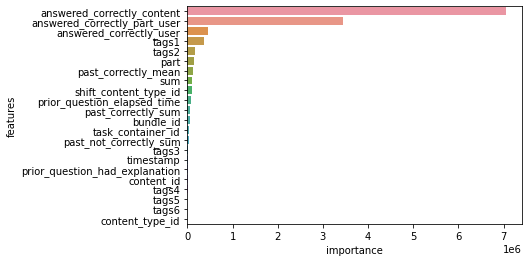

In [52]:
sns.barplot(x='importance', y='features', data=fi.sort_values(by='importance', ascending=False))

In [53]:
import pickle

In [54]:
with open('../models/01_lgbm.pkl','wb') as f:
    pickle.dump(lgb_model,f)

In [55]:
train_x

,timestamp,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,shift_content_type_id,past_correctly_sum,past_not_correctly_sum,past_correctly_mean,bundle_id,part,tags1,tags2,tags3,tags4,tags5,tags6,answered_correctly_user,sum,answered_correctly_content,answered_correctly_part_user
70973313,49046706,756,0,31,24000.0,1.0,0.0,18,27,0.391357,756.0,2,143.0,114.0,38.0,81.0,NaN,NaN,0.721191,880.0,0.546387,0.375000
30255081,38717846221,5250,0,2159,34000.0,1.0,0.0,1261,1210,0.510254,5248.0,5,170.0,NaN,NaN,NaN,NaN,NaN,0.508301,1328.0,0.516602,0.464111
13897792,10088946038,5303,0,289,6000.0,1.0,0.0,288,143,0.666504,5304.0,5,60.0,NaN,NaN,NaN,NaN,NaN,0.654785,999.0,0.907227,0.652344
50797792,31188068746,734,0,1864,20000.0,1.0,0.0,2097,893,0.701172,734.0,2,138.0,41.0,92.0,102.0,NaN,NaN,0.693359,2262.0,0.655273,0.713379
80187457,21778159429,2948,0,6,27000.0,0.0,0.0,8,4,0.615234,2946.0,4,136.0,67.0,92.0,NaN,NaN,NaN,0.604492,26.0,0.219849,0.666504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3783482,41378447131,9176,0,974,114000.0,1.0,0.0,726,286,0.716797,9176.0,5,89.0,NaN,NaN,NaN,NaN,NaN,0.714844,759.0,0.500000,0.719238
24097630,41048441052,2082,0,173,37000.0,1.0,0.0,253,87,0.741699,2080.0,3,136.0,81.0,92.0,NaN,NaN,NaN,0.737793,549.0,0.978027,0.758789
95473131,28702442810,4123,0,251,33000.0,1.0,0.0,235,150,0.608887,4124.0,5,177.0,NaN,NaN,NaN,NaN,NaN,0.582520,363.0,0.731934,0.716797
91514055,16308616471,8157,0,6221,72000.0,1.0,0.0,6427,2226,0.742676,8152.0,7,98.0,84.0,97.0,135.0,162.0,NaN,0.729004,6952.0,0.664062,0.757324


In [42]:
train_x.shape

(7880978, 23)